In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import pandas as pd
import scipy as sp
import scipy.stats as spst
import scipy.special as spsp
from scipy.integrate import quad, dblquad

import pyfeng as pf

# Equivalent CEV Volatility ($0<\beta<1$)

In [2]:
set_no = 4 # 4, 13, 19
title = f'set_{set_no:02d}'

# Equivalent BS vol model
m_bs, df, ref = pf.SabrHagan2002.init_benchmark(set_no)
# Equivalent CEV vol model
m_cev, *_ = pf.SabrChoiWu2021H.init_benchmark(set_no)
print(m_bs.__dict__)

fwd = ref['args_pricing']['spot']
texp = ref['args_pricing']['texp']
strike_exact = ref['args_pricing']['strike']
alpha = m_bs.sigma/np.power(ref['args_pricing']['spot'],1.0 - m_bs.beta)

{'sigma': 0.25, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.3, 'rho': -0.5, 'beta': 0.3}


In [3]:
if ref['is_iv']:
    # Calculate price if vol is given
    vol_exact = ref['val']
    p_exact = pf.Bsm(ref['val']).price(**ref['args_pricing'])
else:
    # Calculate vol if price is given
    p_exact = ref['val']
    vol_exact = pf.Bsm(None).impvol(ref['val'], **ref['args_pricing'])

# Calculate cdf
cdf_exact = 1 + np.diff(p_exact, prepend=fwd)/np.diff(strike_exact, prepend=0.0) 

In [4]:
strike = np.arange(0.1, 2, 0.01)*fwd

vol_bs = m_bs.vol_smile(strike, fwd, texp)
vol_cev = m_cev.vol_smile(strike, fwd, texp)

cdf_bs = m_bs.cdf_numeric(strike, fwd, texp)
cdf_cev = m_cev.cdf_numeric(strike, fwd, texp)

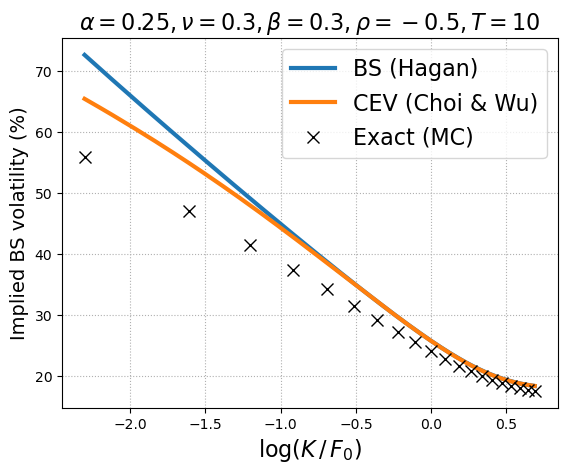

In [5]:
savefig = False

vol_arr = [vol_bs, vol_cev]
K_arr = [strike, strike]

labels = ['BS (Hagan)', 'CEV (Choi & Wu)']
ls = ['-', '-']

for k in np.arange(2):  # len(vol_arr)
    plt.plot(np.log(K_arr[k]/fwd), vol_arr[k]*100, linestyle=ls[k], linewidth=3)

plt.plot(np.log(strike_exact/fwd), vol_exact*100, 'kx', markersize=8)

plt.ylabel('Implied BS volatility (%)', fontsize=14)
plt.xlabel(r'$\log(K\,/\,F_0)$', fontsize=16)
plt.legend(['BS (Hagan)', 'CEV (Choi & Wu)', 'Exact (MC)'], fontsize=16, loc=1)
plt.title(fr'$\alpha={alpha:0.2f}, \nu={m_bs.vov}, \beta={m_bs.beta}, \rho={m_bs.rho}, T={int(texp):d}$', fontsize=16)

plt.grid(linestyle=':')
if savefig:
    plt.savefig(f'CevSABR_vol_{title}.pdf', bbox_inches='tight')
    plt.savefig(f'CevSABR_vol_{title}.png', bbox_inches='tight')
plt.show()

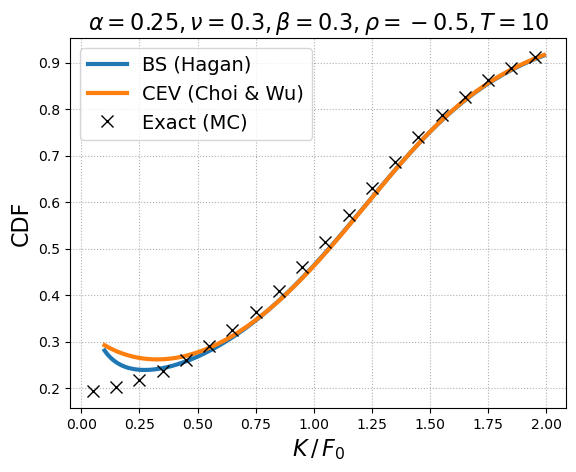

In [6]:
savefig = False

vol_arr = [cdf_bs, cdf_cev]
K_arr = [strike, strike]

labels = ['BS (Hagan)', 'CEV (Choi & Wu)']
ls = ['-', '-']

for k in np.arange(2):  # len(vol_arr)
    plt.plot(K_arr[k]/fwd, vol_arr[k], linestyle=ls[k], linewidth=3)

shift = np.diff(strike_exact, prepend=0.0)
plt.plot((strike_exact-shift/2)/fwd, cdf_exact, 'kx', markersize=8)

plt.ylabel('CDF', fontsize=16)
plt.xlabel(r'$K\,/\,F_0$', fontsize=16)
plt.legend(['BS (Hagan)', 'CEV (Choi & Wu)', 'Exact (MC)'], fontsize=14, loc=2)
plt.title(fr'$\alpha={alpha:0.2f}, \nu={m_bs.vov}, \beta={m_bs.beta}, \rho={m_bs.rho}, T={int(texp):d}$', fontsize=16)

plt.grid(linestyle=':')
if savefig:
    plt.savefig(f'CevSABR_cdf_{title}.pdf', bbox_inches='tight')
    plt.savefig(f'CevSABR_cdf_{title}.png', bbox_inches='tight')
plt.show()

# Normal SABR Option Pricing ($\beta=0$)

In [7]:
vov = 1.5  # 0.5, 1., 1.5, 2.
savefig = False

sigma, rho, texp = 1.0, -0.5, 1.0
strike = np.arange(-3., 3.0001, 0.05)

In [8]:
# Hagan's normal vol approximation

m0 = pf.SabrNormVolApprox(sigma, vov, rho)
v0 = m0.vol_smile(strike, 0.0, texp)
cdf0 = m0.cdf_numeric(strike, 0.0, texp)

In [9]:
# Analytic integral approximation

m = pf.SabrNormAnalyticInt(sigma, vov, rho)
v3 = m.vol_smile(strike, 0.0, texp)
cdf3 = m.cdf_numeric(strike, 0.0, texp)
#m.quad_correction = True
#v4 = m.vol_smile(strike, 0.0, texp)

In [10]:
# Quad integral 

p2 = m.price_quad(strike, 0.0, texp)
v2 = pf.Norm(1.).impvol(p2, strike, 0., texp)
cdf2 = 1-(m.price_quad(strike-0.001, 0.0, texp) - m.price_quad(strike+0.001, 0.0, texp))/0.002

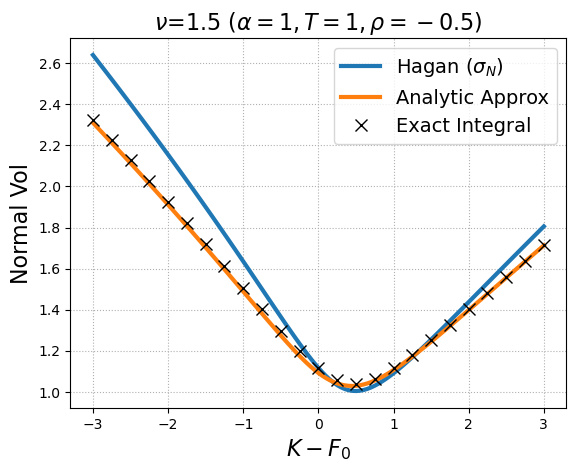

In [11]:
plt.plot(strike, v0, linewidth=3)
plt.plot(strike, v3, linewidth=3)

plt.plot(strike[::5], v2[::5], 'kx', markersize=8)
plt.grid(linestyle=':')

plt.legend(['Hagan ($\sigma_N$)', 'Analytic Approx', 'Exact Integral'], fontsize=14)
plt.xlabel('$K - F_0$', fontsize=16)
plt.ylabel('Normal Vol', fontsize=16)
plt.title(fr'$\nu$={vov} ($\alpha=1, T=1, \rho=-0.5$)', fontsize=16)
if savefig:
    plt.savefig(f'NormSABR_vol_vov_{vov}.png', bbox_inches='tight')
    plt.savefig(f'NormSABR_vol_vov_{vov}.pdf', bbox_inches='tight')
plt.show()

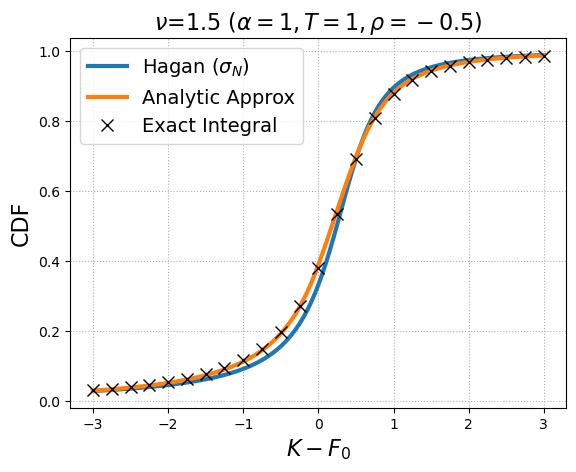

In [12]:
plt.plot(strike, cdf0, linewidth=3)
plt.plot(strike, cdf3, linewidth=3)

plt.plot(strike[::5], cdf2[::5], 'kx', markersize=8)
plt.grid(linestyle=':')

plt.legend(['Hagan ($\sigma_N$)', 'Analytic Approx', 'Exact Integral'], fontsize=14)
plt.xlabel('$K - F_0$', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title(fr'$\nu$={vov} ($\alpha=1, T=1, \rho=-0.5$)', fontsize=16)
if savefig:
    plt.savefig(f'NormSABR_cdf_vov_{vov}.png', bbox_inches='tight')
    plt.savefig(f'NormSABR_cdf_vov_{vov}.pdf', bbox_inches='tight')
plt.show()